1．实现公开的MNIST手写数字数据集的分类或自选数据的分类；包括数据获取、训练集和测试集创建、工作空间创建、训练数据导入； 

2．调用scikit-learn的基本库，自己实现利用Parzen窗、Gaussian 分布和KNN实现MINIST的概率密度估计并进行分类,及基于训练好模型的测试、实验报告撰写。

3．利用第三方优化工具包实现参数的优化，并与scikit-learn中标准算法进行自己实现算法的时间复杂度的对比。

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold
from sklearn.metrics import accuracy_score

# 获取数据
data = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
pixel_values, targets = data
targets = targets.astype(int)
pixel_array = pixel_values.to_numpy()

/opt/homebrew/Caskroom/miniconda/base/envs/datasci/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
# 使用 t-SNE 进行降维
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=25)
transformed_data = tsne.fit_transform(pixel_array)

In [12]:
def visualize_tsne(X, y):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=sns.color_palette("hls", 10), legend="full", alpha=0.8)
    plt.title('t-SNE visualization of MNIST data')
    plt.show()

# 可视化降维后的数据
visualize_tsne(transformed_data, targets)

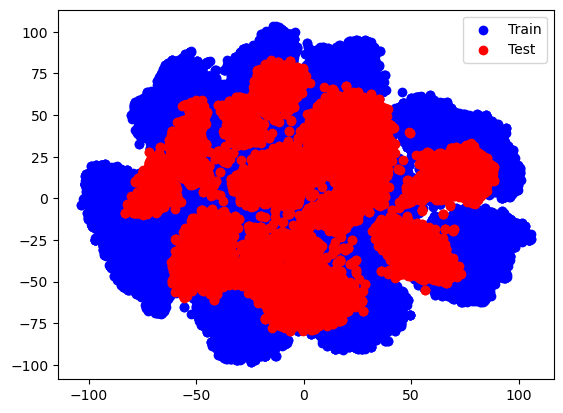

In [13]:
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

# 执行 Parzen 窗口密度估计的函数
def parzen_window_estimation(X_train, X_test, h):
    n_samples, n_features = X_train.shape
    scores = np.zeros((X_test.shape[0], n_samples))
    for i, x in enumerate(X_test):
        # 为每个点 x 计算多元正态密度
        for j, sample in enumerate(X_train):
            kernel = multivariate_normal(mean=sample, cov=h**2 * np.identity(n_features))
            scores[i, j] = kernel.pdf(x)
    return scores.mean(axis=1)

# 根据 Parzen 窗口估计进行分类的函数
def classify_parzen_window(X_train, y_train, X_test, h):
    unique_classes = np.unique(y_train)
    predictions = np.zeros(X_test.shape[0])
    for class_val in unique_classes:
        # 对每个类应用 Parzen 窗口估计
        class_mask = y_train == class_val
        pdf_estimates = parzen_window_estimation(X_train[class_mask], X_test, h)
        # 假设类别概率相等，取似然度最大值
        if class_val == 0 or pdf_estimates > predictions:
            predictions = pdf_estimates
            predicted_class = class_val
    return predicted_class

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(pixel_array, targets, test_size=0.2, random_state=42)

# 为 Parzen 窗口设置带宽参数
h = 1.0 # 这是一个任意值；实际操作中，你需要通过系统方法选择它

# 对测试集进行分类
predictions = np.array([classify_parzen_window(X_train, y_train, X_test[i].reshape(1, -1), h) for i in range(len(X_test))])

In [ ]:
# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print(f'准确率: {accuracy}')